In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

In [3]:
read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

In [4]:
df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                category
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City     

# Analyze

In [6]:
df.head()

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,air_Country,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country
0,Removal,M,Non-Criminal,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
1,Removal,M,Non-Criminal,No,1.0,38.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
2,Removal,M,Non-Criminal,No,1.0,20.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
3,Removal,M,Non-Criminal,No,1.0,29.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
4,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala


No duplicate records.

In [7]:
pre = len(df)
df.drop_duplicates(inplace=True)
post = len(df)
assert (pre - post) == 0

# Global variables

In [8]:
number_of_records = len(df)
print(f'Number of records: {number_of_records}')

Number of records: 1763020


No missing values in ID fields. IDs repeat.

In [9]:
unique_MissionID = len(set(df['MissionID']))
print(f"Unique MissionID values: {unique_MissionID}")

Unique MissionID values: 14973


In [10]:
assert sum(df['MissionID'].isnull()) == 0

In [11]:
unique_MissionNumber = len(set(df['MissionNumber']))
print(f"Unique MissionNumber values: {unique_MissionNumber}")

Unique MissionNumber values: 14973


In [12]:
assert sum(df['MissionNumber'].isnull()) == 0

One to one relationship of MissionID to MissionNumber. These fields seem to be equivalent.

In [13]:
assert sum(df.groupby(['MissionID', 'MissionNumber'])['MissionNumber'].nunique() > 1) == 0

In [14]:
unique_AlienMasterID = len(set(df['AlienMasterID']))
print(f"Unique AlienMasterID values: {unique_AlienMasterID}")

Unique AlienMasterID values: 1733555


In [15]:
assert sum(df['AlienMasterID'].isnull()) == 0

In [16]:
earliest_record = df['MissionDate'].min()
print(f'Earliest record: {earliest_record}')

Earliest record: 2010-10-01 00:00:00


In [17]:
latest_record = df['MissionDate'].max()
print(f'Earliest record: {latest_record}')

Earliest record: 2018-12-05 00:00:00


In [18]:
df.set_index('MissionDate', inplace=True)

In [19]:
number_of_pickup_airports = len(set(df['PULOC']))
number_of_dropoff_airports = len(set(df['DropLoc']))
print(f'Number of pickup airports: {number_of_pickup_airports}')
print(f'Number of dropoff airports: {number_of_dropoff_airports}')

Number of pickup airports: 84
Number of dropoff airports: 207


Some airport codes are missing full name and other details. Clean if necessary:

In [63]:
group = df.groupby(['air_AirportName', 'PULOC']).size().reset_index(name='count')
s = group['PULOC'].value_counts()
missing_air_AirportName = list(s[s != 1].index)
print(f'Pickup airports missing full name: {missing_air_AirportName}')

Pickup airports missing full name: ['KALB']


In [64]:
group = df.groupby(['air2_AirportName', 'DropLoc']).size().reset_index(name='count')
s = group['DropLoc'].value_counts()
missing_air2_AirportName = list(s[s != 1].index)
print(f'Dropoff airports missing full name: {missing_air2_AirportName}')

Dropoff airports missing full name: ['FCBB', 'HBBA', 'FYWH', 'KMHR', 'KALB', 'NSFA', 'KMDW', 'SBCF']


Top pickup airports.

In [176]:
df['PULOC'].value_counts().head(10)

KAEX    239911
KBRO    204895
KIWA    196150
KHRL    154138
KELP    136127
KSAT    107434
KCSG     80797
KMDT     76348
KLRD     56409
KMIA     55588
Name: PULOC, dtype: int64

Top dropoff airports.

In [66]:
df['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       327010
Ramon Villeda Morales International Airport             202955
Alexandria International Airport                        169316
El Salvador International Airport                       157773
Valley International Airport                            148700
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87408
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62943
Name: air2_AirportName, dtype: int64

In [85]:
pickup_countries = set(df['air_Country'])
print(f'Number of pickup countries: {len(pickup_countries)}')

Number of pickup countries: 11


In [86]:
dropoff_countries = set(df['air2_Country'])
print(f'Number of dropoff countries: {len(dropoff_countries)}')

Number of dropoff countries: 116


In [88]:
all_countries = pickup_countries.union(dropoff_countries)
print(f'Total countries in ICE Air network: {len(dropoff_countries)}')

Total countries in ICE Air network: 116


In [91]:
df['CountryOfCitizenship'].value_counts().head(15)

MEXICO                597172
GUATEMALA             421468
HONDURAS              304777
EL SALVADOR           256900
DOMINICAN REPUBLIC     31704
ECUADOR                25690
HAITI                  23308
NICARAGUA              18679
COLOMBIA               14520
JAMAICA                12801
INDIA                   8952
CHINA                   4460
CUBA                    3658
BANGLADESH              2831
SOMALIA                 2668
Name: CountryOfCitizenship, dtype: int64

In [119]:
pickup_names = df[['PULOC', 'air_AirportName']].drop_duplicates()
pickup_names.set_index('PULOC', inplace=True)
dropoff_names = df[['DropLoc', 'air2_AirportName']].drop_duplicates()
dropoff_names.set_index('DropLoc', inplace=True)

In [130]:
pickup_dict = pickup_names.to_dict()['air_AirportName']
dropoff_dict = dropoff_names.to_dict()['air2_AirportName']

In [137]:
airport_dict = {**pickup_dict, **dropoff_dict}

In [161]:
df['NonCriminal'] = df['Criminality'] == 'NC'

# Boeing field values

In [242]:
airport = 'KBFI'
airport_name = airport_dict[airport]

In [243]:
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

In [244]:
pickup_df = df[pickup]
dropoff_df = df[dropoff]

In [245]:
len(set(pickup_df['AlienMasterID']))

34443

In [246]:
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
annual_pickups = pickup_df['2011':'2018']['AlienMasterID'].resample('AS').nunique()
annual_dropoffs = dropoff_df['2011':'2018']['AlienMasterID'].resample('AS').nunique()

In [247]:
annual_pickups

MissionDate
2011-01-01    6530
2012-01-01    5402
2013-01-01    4603
2014-01-01    3600
2015-01-01    2852
2016-01-01    3178
2017-01-01    3462
2018-01-01    3278
Freq: AS-JAN, Name: AlienMasterID, dtype: int64

In [248]:
annual_dropoffs

MissionDate
2011-01-01     708
2012-01-01    1385
2013-01-01    1983
2014-01-01    1943
2015-01-01    2508
2016-01-01    2778
2017-01-01    1451
2018-01-01    2317
Freq: AS-JAN, Name: AlienMasterID, dtype: int64

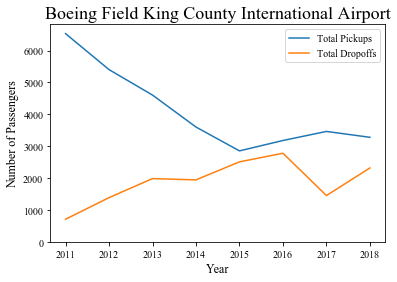

In [249]:
def plot(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=12)
    ax.set_ylim(0)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_title(f'{airport_name}', fontsize=18)
    
    fig.savefig('../output/ICEFlights.png')
    return fig, ax

annual_pickups.rename('Total Pickups', inplace=True)
annual_dropoffs.rename('Total Dropoffs', inplace=True)

plot = plot([annual_pickups, annual_dropoffs]);

In [250]:
pickup_df['Criminality'].value_counts(dropna=False)

C      22181
NC     11640
NaN      645
Name: Criminality, dtype: int64

In [251]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS').sum()

In [252]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

In [253]:
annual_data['total'].max()

34282.0

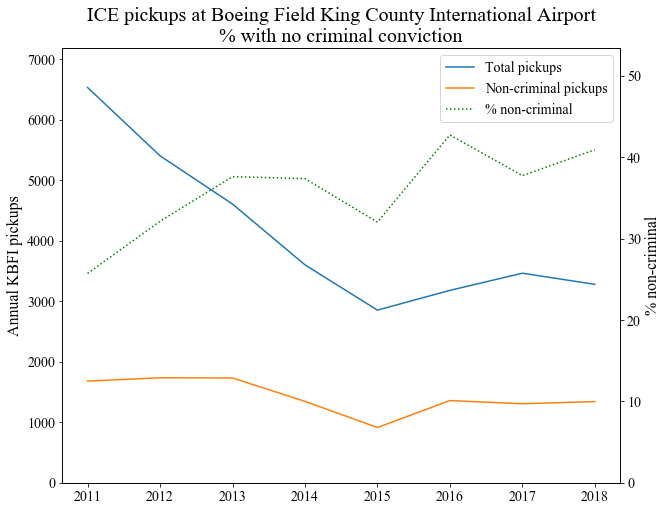

In [257]:
annual_data = annual_non_criminal['2011':'2018']

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Mapping

In [56]:
df.reset_index(inplace=True)

In [57]:
groupby = df.groupby(['MissionYear', 'R-T', 'PULOC', 'DropLoc'])

In [58]:
table = groupby.size().reset_index()

In [59]:
flights = groupby['MissionID'].nunique().reset_index()['MissionID']

In [60]:
table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers']

In [61]:
table['flights'] = flights

In [62]:
table.reset_index(drop=True, inplace=True)

In [63]:
all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')

In [64]:
table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')

In [65]:
table

,year,R-T,pickup_airport,dropoff_airport,passengers,flights
0,2010,R,KAEX,KHRL,2025,23
1,2010,R,KAEX,KLRD,27,2
2,2010,R,KAEX,MDSD,549,6
3,2010,R,KAEX,MGGT,1441,13
4,2010,R,KAEX,MHLM,454,5
5,2010,R,KAEX,MHTG,756,8
6,2010,R,KAEX,MKJP,201,3
7,2010,R,KAEX,MSLP,438,5
8,2010,R,KAEX,SEGU,343,6
9,2010,R,KAEX,SKBO,244,3


# Tracking individual

In [66]:
df.columns

Index(['MissionDate', 'Status', 'Sex', 'Convictions', 'GangMember', 'ClassLvl',
       'Age', 'MissionNumber', 'PULOC', 'DropLoc', 'StrikeFromList',
       'ReasonStruck', 'R-T', 'Code', 'CountryOfCitizenship', 'Juvenile',
       'MissionWeek', 'MissionQuarter', 'MissionYear', 'MissionMonth',
       'Criminality', 'FamilyUnitFlag', 'UnaccompaniedFlag', 'AlienMasterID',
       'MissionID', 'air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country', 'air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'NonCriminal'],
      dtype='object')

In [67]:
df.head()

,MissionDate,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionNumber,PULOC,DropLoc,...,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,NonCriminal
0,2010-10-01,Removal,M,Non-Criminal,No,1.0,18.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
1,2010-10-01,Removal,M,Non-Criminal,No,1.0,38.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
2,2010-10-01,Removal,M,Non-Criminal,No,1.0,20.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
3,2010-10-01,Removal,M,Non-Criminal,No,1.0,29.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
4,2010-10-01,Removal,M,Non-Criminal,No,1.0,21.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False


In [68]:
count = df.groupby(['AlienMasterID']).size().reset_index(name='count')

In [69]:
count.set_index('AlienMasterID', inplace=True)

In [70]:
df.set_index('AlienMasterID', inplace=True)

In [71]:
df = df.join(count, how='left')

In [72]:
more_than_one = df['count'] > 1

In [73]:
multiple_alienID = df[more_than_one]

In [74]:
multiple_alienID.to_csv('../output/multiple_alienID.csv.gz', compression='gzip', sep='|')

# By nationality

In [95]:
nationality = 'CAMBODIA'

In [96]:
nationality_df = df[df['CountryOfCitizenship'] == nationality]

In [97]:
nationality_df.reset_index(inplace=True)

In [98]:
groupby = nationality_df.groupby(['MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [99]:
table = groupby['AlienMasterID'].nunique().reset_index(name='Deportees')

In [100]:
repatriations = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [101]:
transfers.head()

,MissionDate,R-T,PULOC,DropLoc,Deportees
0,2010-10-04,T,KMDT,KAEX,1
1,2010-10-12,T,KMDT,KAEX,3
2,2010-10-15,T,KBFL,KIWA,1
3,2010-10-15,T,KOAK,KIWA,2
4,2010-10-16,T,KIWA,KBFI,2


In [102]:
transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
repatriations.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [103]:
repatriations.set_index('MissionDate', inplace=True)

In [104]:
r_cum = repatriations['Deportees'].cumsum()
t_cum = transfers['Deportees'].cumsum()

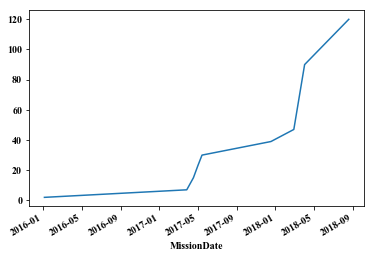

In [105]:
r_cum.plot();

## Juveniles only

In [106]:
juv_table = groupby['Juvenile'].sum().reset_index(name='Juveniles')

In [107]:
juv_repatriations = juv_table[juv_table['R-T'] == 'R'].copy()
juv_transfers = juv_table[juv_table['R-T'] == 'T'].copy()

In [108]:
juv_repatriations.set_index('MissionDate', inplace=True)

In [109]:
juv_r_cum = juv_repatriations['Juveniles'].cumsum()

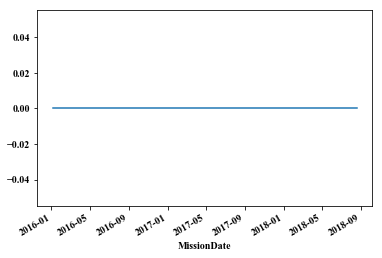

In [110]:
juv_r_cum.plot()

In [111]:
repatriations['Juveniles'] = juv_repatriations['Juveniles']

In [112]:
repatriations['JuvPercent'] = juv_repatriations['Juveniles'] / repatriations['Deportees']

In [113]:
repatriations.tail(20)

,R-T,PULOC,DropLoc,Deportees,Juveniles,JuvPercent
MissionDate,,,,,,
2016-01-05,R,KIWA,VDPP,2,False,0.0
2017-03-28,R,KAEX,VDPP,5,False,0.0
2017-04-18,R,KIWA,VDPP,8,False,0.0
2017-05-02,R,KIWA,VDPP,8,False,0.0
2017-05-15,R,KIWA,VDPP,7,False,0.0
2017-12-18,R,KELP,VDPP,9,False,0.0
2018-02-28,R,KIWA,VDPP,8,False,0.0
2018-04-03,R,KELP,VDPP,43,False,0.0
2018-08-20,R,KELP,VDPP,30,False,0.0


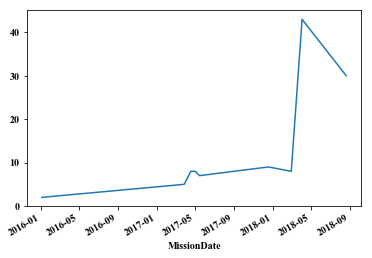

In [115]:
repatriations['Deportees'].plot();

# Rate of flights

## Global

In [192]:
df.reset_index(inplace=True)
df.set_index('MissionDate', inplace=True)

In [193]:
daily_flights = df['MissionID'].resample('D').nunique()
monthly_flights = df['MissionID'].resample('M').nunique()
quarterly_flights = df['MissionID'].resample('Q').nunique()
annual_flights = df.loc['2011':'2018']['MissionID'].resample('AS').nunique()

In [194]:
annual_flights

MissionDate
2011-01-01    2117
2012-01-01    2368
2013-01-01    2041
2014-01-01    2094
2015-01-01    1306
2016-01-01    1540
2017-01-01    1514
2018-01-01    1545
Freq: AS-JAN, Name: MissionID, dtype: int64

In [195]:
monthly_means = pd.DataFrame(columns=['year', 'monthly_mean_flights'])
for year in range(2011, 2019):
    mean = monthly_flights[f'{year}'].mean()
    monthly_means = monthly_means.append({'year':year, 'monthly_mean_flights':mean}, ignore_index=True)

In [196]:
monthly_means

,year,monthly_mean_flights
0,2011.0,176.416667
1,2012.0,197.333333
2,2013.0,170.083333
3,2014.0,174.500000
4,2015.0,108.833333
5,2016.0,128.333333
6,2017.0,126.166667
7,2018.0,128.750000


## Specific airport

In [197]:
airport = 'KBFI'

In [198]:
pickup_airport_df = df[df['PULOC'] == airport]
dropoff_airport_df = df[df['DropLoc'] == airport]

In [199]:
daily_flights = pickup_airport_df['MissionID'].resample('D').nunique()
monthly_flights = pickup_airport_df['MissionID'].resample('M').nunique()
monthly_pickups = pickup_airport_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_airport_df['AlienMasterID'].resample('M').nunique()
quarterly_flights = pickup_airport_df['MissionID'].resample('Q').nunique()
annual_flights = pickup_airport_df.loc['2011':'2018']['MissionID'].resample('AS').nunique()
annual_pickups = pickup_airport_df.loc['2011':'2018']['AlienMasterID'].resample('AS').nunique()
annual_dropoffs = pickup_airport_df.loc['2011':'2018']['AlienMasterID'].resample('AS').nunique()

In [200]:
annual_flights

MissionDate
2011-01-01    100
2012-01-01     58
2013-01-01     49
2014-01-01     47
2015-01-01     34
2016-01-01     54
2017-01-01     51
2018-01-01     50
Freq: AS-JAN, Name: MissionID, dtype: int64

In [201]:
monthly_mean_pickups = pd.DataFrame(columns=['year', 'monthly_mean_pickups'])
for year in range(2011, 2019):
    mean = monthly_pickups[f'{year}'].mean()
    monthly_mean_pickups = monthly_mean_pickups.append({'year':year, 'monthly_mean_pickups':mean}, ignore_index=True)

In [202]:
monthly_mean_pickups

,year,monthly_mean_pickups
0,2011.0,544.166667
1,2012.0,450.166667
2,2013.0,383.583333
3,2014.0,300.000000
4,2015.0,237.666667
5,2016.0,264.833333
6,2017.0,288.500000
7,2018.0,273.166667


In [134]:
pickup_airport_df.groupby(['MissionYear', 'R-T', 'CountryOfCitizenship'])['AlienMasterID'].nunique()

MissionYear  R-T  CountryOfCitizenship
2010         R    MEXICO                  1338
             T    CAMBODIA                   1
                  ECUADOR                   11
                  EL SALVADOR               34
                  GUATEMALA                 98
                  HONDURAS                  52
                  MEXICO                     1
                  NICARAGUA                  3
2011         R    CHINA                      6
                  MEXICO                  5729
             T    AFGHANISTAN                1
                  ARGENTINA                  1
                  BULGARIA                   1
                  CAMBODIA                   1
                  CHINA                      1
                  COLOMBIA                   7
                  DOMINICAN REPUBLIC         3
                  ECUADOR                   19
                  EL SALVADOR              189
                  GUATEMALA                380
                  HON

# Data needs

Cambodia
- Flights from US annually
- Halt of repatriations in 2017
- Cambodians leaving King Co
- % non-criminal